# Example 3: Query multiple items using paging
See more about paging here: https://graphql.org/learn/pagination/

In [1]:
import sys
from sgqlc.operation import Operation
from pdp_schema import pdp_schema as schema
from pdp_graphql_client_python import client

## 1. Set the API endpoint
Ensure the endpoint is set to the PDP (FARO) schema on INT

In [2]:
%set_env PDP_API=https://graphql-api.pdp.int.srgssr.ch/graphql

env: PDP_API=https://graphql-api.pdp.int.srgssr.ch/graphql


## 2. Show available queries

In [3]:
# *Page queries allow for paging
# first=[number of queries to retrieve, e.g. *first* 10 queries]
# after=[id or cursor position from which to start]
schema.Query

type Query {
  faroProgramPage(first: Int!, after: String): FaroProgramPage!
  faroPrograms(ids: [String!]!): [FaroProgram]!
  randomFaroPrograms: [FaroProgram!]!
  faroItemPage(first: Int!, after: String): FaroItemPage!
  faroItems(ids: [String!]!): [FaroItem]!
  faroItemsByPlayUrn(urns: [String!]!): [FaroItem]!
  faroItemsByPlayUrnGraphDb(urns: [String!]!): [FaroItem]!
  randomFaroItems: [FaroItem!]!
}

## 3. Configure the query operation with paging
To query pages programmatically we parametrize the query

In [4]:
from sgqlc.types import Variable, non_null

op = Operation(schema.Query, name='PagingQuery', variables={'first':non_null(int), 'after':str})

In [5]:
# return current query (empty)
op

query PagingQuery($first: Int!, $after: String) {
}

In [6]:
# select query type and configure with argument
faro = op.faro_program_page(first=Variable('first'), after=Variable('after'))

In [7]:
# return current query (empty)
op

query PagingQuery($first: Int!, $after: String) {
  faroProgramPage(first: $first, after: $after) {
    edges {
      id
      bu
      mediaType
      episodeIds
      sTit
      sDatStart
      sGef
      pTit
      department
      workgroup
      seriesNr
    }
    cursor
  }
}

## 4. Select fields of interest

In [8]:
# select fields to be retured
faro.edges.id()
faro.edges.media_type()
faro.edges.s_dat_start()
faro.edges.s_gef()
faro.edges.s_tit()
faro.edges.series_nr()
faro.cursor()

cursor

In [9]:
# return current query
op

query PagingQuery($first: Int!, $after: String) {
  faroProgramPage(first: $first, after: $after) {
    edges {
      id
      mediaType
      sDatStart
      sGef
      sTit
      seriesNr
    }
    cursor
  }
}

## 5. Retrieve the data

In [10]:
# constants
page_size = 100
page_requests = 100

In [11]:
# initialize with first query
data = client.run_query(op, {'first':page_size})

results = (op + data).faro_program_page

if not results.edges:
    print('No items!', file=sys.stderr)
    raise SystemExit()

In [12]:
from tqdm.notebook import tnrange
for i in tnrange(page_requests, desc="Downloading data"):
    # query page
    data = client.run_query(op, {'first':page_size, 'after':results.cursor})
    
    # convert page to object oriented results
    page = (op + data).faro_program_page

    # extract new edges and update cursor
    results.edges += page.edges
    results.cursor = page.cursor

In [13]:
print(f'INFO - Retrieved {len(results.edges):,} FaroItems')

INFO - Retrieved 10,100 FaroItems


## 6. Plot the year distribution of first display

In [14]:
from collections import Counter
from datetime import date

# count year occurrences
c = Counter(date.fromisoformat(x.s_dat_start).year for x in results.edges if x.s_dat_start)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

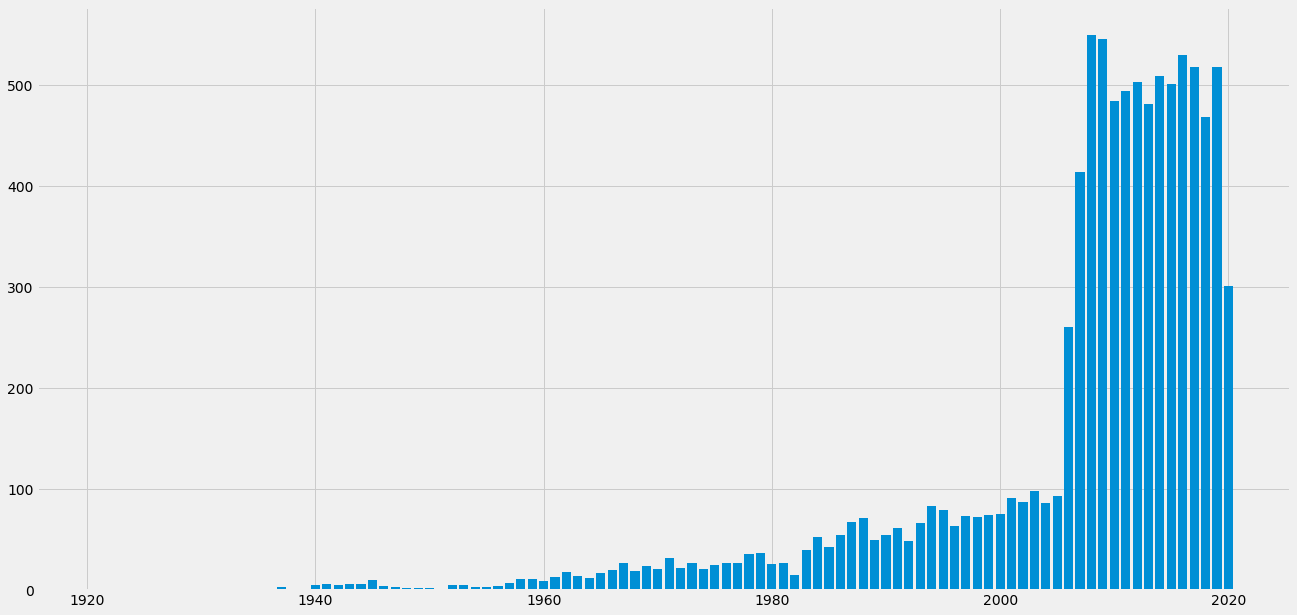

In [16]:
with plt.style.context('fivethirtyeight'):
    plt.bar(c.keys(), c.values())

## 7. Load data into a `pandas` dataframe

In [17]:
import pandas as pd

In [18]:
results.edges[0].__fields_cache__

OrderedDict([('id', id: String!),
             ('media_type', mediaType: String),
             ('s_dat_start', sDatStart: String),
             ('s_gef', sGef: String),
             ('s_tit', sTit: String),
             ('series_nr', seriesNr: Int)])

In [19]:
# todo: find better way to import data into pandas
df = pd.DataFrame([x.__json_data__ for x in results.edges])

In [20]:
df

,sGef,sTit,mediaType,sDatStart,seriesNr,id
0,Doppelpunkt,None,audio,1994-06-26,0.0,00000d68-1776-4355-b437-29f33219f956
1,None,None,audio,2012-11-26,NaN,00001741-a812-44ad-aad4-f235af1258f9
2,Oz,Contribuziun,audio,2006-11-21,NaN,00002453-5e11-4818-a9f0-abaeeb948e8b
3,None,None,audio,2012-09-28,NaN,00002561-ad3d-4bff-a9ae-1fe06901cc29
4,None,None,None,None,0.0,000042a5-b7bd-4787-a6ce-dd0fd96e2613
...,...,...,...,...,...,...
10095,None,None,video,None,0.0,01872173-07b4-40de-b534-2589f8f621d6
10096,None,None,audio,2008-04-07,NaN,018728e9-8c8c-4bc4-95dd-5e678eed5c0e
10097,100 Sekunden Wissen,None,audio,2015-04-29,NaN,01872be6-3d4c-4e40-966c-8475039806a6
10098,None,Urban Gardening,video,2015-07-23,3.0,01872c72-ac9e-4045-b91f-4f56045f3e61
